In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler


In [5]:

# Load the dataset
url = '/content/AirPassengers.csv'
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')




            #Passengers  Weather_Index
Month                                 
1949-01-01          112     129.640523
1949-02-01          118     122.001572
1949-03-01          132     141.787380
1949-04-01          129     151.408932
1949-05-01          121     139.675580


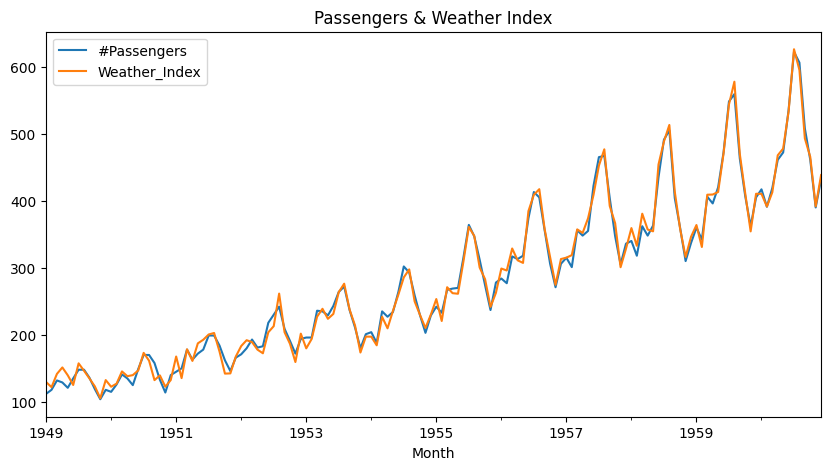

In [6]:
# Simulate another variable (e.g., Weather Index)
np.random.seed(0)
df['Weather_Index'] = df['#Passengers'] + np.random.normal(0, 10, len(df))
print(df.head())
# Plot data
df.plot(figsize=(10, 5))
plt.title("Passengers & Weather Index")
plt.show()


In [7]:

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

df_scaled = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)

# Check stationarity and difference if needed
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    return result[1]  # p-value

# Differencing if not stationary
df_diff = df_scaled.diff().dropna()

# Fit the VAR model
model = VAR(df_diff)
results = model.fit(maxlags=15, ic='aic')

# Forecasting
forecast_steps = 12
forecast = results.forecast(df_diff.values[-results.k_ar:], steps=forecast_steps)

# Convert to DataFrame and reverse differencing
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=df.index[-1], periods=forecast_steps+1, freq='MS')[1:],
                           columns=df.columns)

# Cumulative sum to reverse differencing
last_values = df_scaled.iloc[-1]
forecast_reversed = forecast_df.cumsum() + last_values

# Inverse transform the data
forecast_original = pd.DataFrame(scaler.inverse_transform(forecast_reversed),
                                 columns=df.columns, index=forecast_reversed.index)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


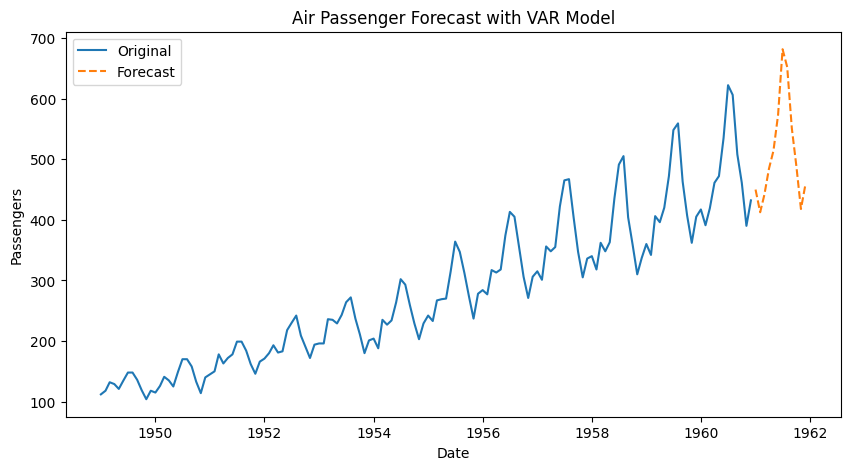

In [8]:

# Plot Forecast
plt.figure(figsize=(10,5))
plt.plot(df.index, df['#Passengers'], label='Original')
plt.plot(forecast_original.index, forecast_original['#Passengers'], label='Forecast', linestyle='--')
plt.legend()
plt.title("Air Passenger Forecast with VAR Model")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.show()
